In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew, kurtosis
from sklearn.model_selection import GridSearchCV


In [6]:

# Load the provided files to understand their structure
# file_paths = {
#     "balance": "hc100_balance.csv",
#     "hurriedpace": "hc100_hurriedpace.csv",
#     "hurriedpace_mat": "hc100_hurriedpace_mat.csv",
#     "selfpace": "hc100_selfpace.csv",
#     "selfpace_mat": "hc100_selfpace_mat.csv",
#     "selfpace_matturn": "hc100_selfpace_matturn.csv",
#     "tandemgait": "hc100_tandemgait.csv",
#     "tug": "hc100_tug.csv"
# }

# Read all files into dataframes
dataframes = {}
# for name, path in file_paths.items():
#     try:
#         dataframes[name] = pd.read_csv(path)
#     except Exception as e:
#         print(f"Error loading {name}: {e}")

# # Display information about the dataframes to understand their structures
# data_info = {name: df.info() for name, df in dataframes.items()}

dataframes['selfpace'] = pd.read_csv(csv_file)
dataframes['tandemgait'] = pd.read_csv(tandemgait_file_name)

print(dataframes)
print("###############################################")
print(file_name)
print("###############################################")


{'selfpace':            Time GeneralEvent ClinicalEvent  L Foot Contact  R Foot Contact  \
0         0 sec    unlabeled     unlabeled               0               0   
1      0.01 sec     Standing     unlabeled               0               0   
2      0.02 sec     Standing     unlabeled               0               0   
3      0.03 sec     Standing     unlabeled               0               0   
4      0.04 sec     Standing     unlabeled               0               0   
...         ...          ...           ...             ...             ...   
4655  46.55 sec     Standing     unlabeled               0               0   
4656  46.56 sec     Standing     unlabeled               0               0   
4657  46.57 sec     Standing     unlabeled               0               0   
4658  46.58 sec     Standing     unlabeled               0               0   
4659  46.59 sec     Standing     unlabeled               0               0   

      L Foot Pressure  R Foot Pressure Walkway_X W

NameError: name 'file_name' is not defined

In [ ]:
# Identify datasets and columns containing IMU and gyroscope data
imu_gyro_columns = {name: [col for col in df.columns if 'Acc' in col or 'Gyro' in col] 
                    for name, df in dataframes.items()}

# Display IMU and gyroscope column mappings for review
imu_gyro_columns_summary = pd.DataFrame.from_dict(imu_gyro_columns, orient='index').T
imu_gyro_columns_summary

In [ ]:
# Select the dataset and relevant columns for analysis
selected_dataset_name = "selfpace"
selected_dataset = dataframes[selected_dataset_name]
# selected_dataset = pd.read_csv(file_name)
imu_columns = ["LowerBack_Acc_X", "LowerBack_Acc_Y", "LowerBack_Acc_Z", "Linsole:Acc_Y"]

# Filter data for these columns, ensuring non-null values
imu_data = selected_dataset[imu_columns].dropna()

# Perform FFT for each axis
fft_results = {}
for column in imu_columns:
    # Remove mean to avoid DC component
    signal = imu_data[column] - imu_data[column].mean()
    
    # Perform FFT
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_result), d=1/50)  # Assuming 50 Hz sampling rate
    
    # Keep only positive frequencies
    fft_results[column] = (freqs[freqs >= 0], np.abs(fft_result[freqs >= 0]))

# Plot FFT results
for column, (freqs, fft_values) in fft_results.items():
    plt.figure()
    plt.plot(freqs, fft_values)
    plt.title(f"Frequency Spectrum of {column} (Selfpace Dataset)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [ ]:
# Define a function for moving RMS calculation
def moving_rms(signal, window_size):
    return np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='valid'))

# Select a signal for visualization ("LowerBack_Acc_X")
signal = imu_data["LowerBack_Acc_X"].values

# Calculate moving RMS with a window size of 50 samples (~1 second at 50 Hz)
window_size = 50  # 1 second
rms = moving_rms(signal, window_size)

# Calculate zero-crossing rate
zero_crossings = np.where(np.diff(np.sign(signal)))[0]

# Calculate signal magnitude area (SMA)
sma = np.sum(np.abs(signal))

# Visualize the raw signal, moving RMS, and zero-crossing points
plt.figure(figsize=(12, 6))

# Raw signal
plt.subplot(2, 1, 1)
plt.plot(signal, label="Raw Signal", alpha=0.7)
plt.scatter(zero_crossings, signal[zero_crossings], color='red', label="Zero-Crossings", s=10)
plt.title("Raw Signal and Zero-Crossings")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Moving RMS
plt.subplot(2, 1, 2)
plt.plot(rms, label="Moving RMS (1s window)", color='orange')
plt.title("Amplitude Variability (RMS)")
plt.xlabel("Time (samples)")
plt.ylabel("RMS Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print calculated SMA for reference
sma

In [ ]:
# Define a band-pass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Parameters for the band-pass filter
lowcut = 3  # Lower bound of tremor frequency range (Hz)
highcut = 12  # Upper bound of tremor frequency range (Hz)
fs = 50  # Sampling frequency (Hz)

# Apply the band-pass filter to the signal
filtered_signal = bandpass_filter(signal, lowcut, highcut, fs)

# Compute moving RMS of the filtered signal
filtered_rms = moving_rms(filtered_signal, window_size)

# Determine threshold for tremor detection (e.g., RMS > mean + std)
rms_threshold = filtered_rms.mean() + filtered_rms.std()
tremor_indices = np.where(filtered_rms > rms_threshold)[0]

# Plot the filtered signal and highlight tremor regions
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal, label="Filtered Signal (3-12 Hz)", alpha=0.7)
plt.scatter(tremor_indices, filtered_signal[tremor_indices], color='red', label="Detected Tremor", s=10)
plt.title("Tremor Detection in Filtered Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Summary of tremor detection
num_tremor_samples = len(tremor_indices)
tremor_percentage = (num_tremor_samples / len(filtered_signal)) * 100

num_tremor_samples, tremor_percentage


           Time GeneralEvent ClinicalEvent  L Foot Contact  R Foot Contact  \
0         0 sec    unlabeled     unlabeled               1               1   
1      0.01 sec    unlabeled     unlabeled               1               1   
2      0.02 sec    unlabeled     unlabeled               1               1   
3      0.03 sec    unlabeled     unlabeled               1               1   
4      0.04 sec    unlabeled     unlabeled               1               1   
...         ...          ...           ...             ...             ...   
4381  43.81 sec    unlabeled     unlabeled               0               0   
4382  43.82 sec    unlabeled     unlabeled               0               0   
4383  43.83 sec    unlabeled     unlabeled               0               0   
4384  43.84 sec    unlabeled     unlabeled               0               0   
4385  43.85 sec    unlabeled     unlabeled               0               0   

      L Foot Pressure  R Foot Pressure  \
0                 223

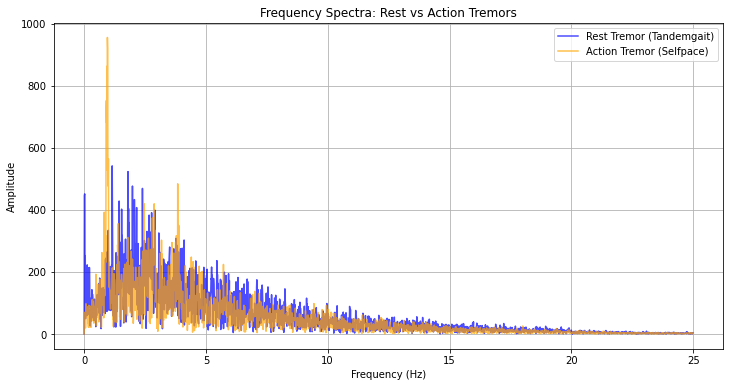

NameError: name 'moving_rms' is not defined

In [7]:
# Select datasets for rest (tandemgait) and action (selfpace)
rest_dataset = dataframes["tandemgait"]
action_dataset = dataframes["selfpace"]

# Select IMU signals for comparison
imu_columns = ["LowerBack_Acc_X", "LowerBack_Acc_Y", "LowerBack_Acc_Z"]
rest_signals = rest_dataset[imu_columns].dropna()
action_signals = action_dataset[imu_columns].dropna()

# Define a function for FFT-based frequency analysis
def compute_fft(signal, fs=50):
    signal = signal - signal.mean()  # Remove mean
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_result), d=1/fs)
    positive_freqs = freqs[freqs >= 0]
    positive_amplitudes = np.abs(fft_result[freqs >= 0])
    return positive_freqs, positive_amplitudes

# Compute FFT for rest and action signals (X-axis as example)
rest_freqs, rest_amplitudes = compute_fft(rest_signals["LowerBack_Acc_X"].values)
action_freqs, action_amplitudes = compute_fft(action_signals["LowerBack_Acc_X"].values)

# Plot frequency spectra for rest and action
plt.figure(figsize=(12, 6))
plt.plot(rest_freqs, rest_amplitudes, label="Rest Tremor (Tandemgait)", alpha=0.7)
plt.plot(action_freqs, action_amplitudes, label="Action Tremor (Selfpace)", alpha=0.7)
plt.title("Frequency Spectra: Rest vs Action Tremors")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Compute RMS for rest and action signals
rest_rms = moving_rms(rest_signals["LowerBack_Acc_X"].values, window_size)
action_rms = moving_rms(action_signals["LowerBack_Acc_X"].values, window_size)

# Plot RMS for rest and action
plt.figure(figsize=(12, 6))
plt.plot(rest_rms, label="Rest Tremor RMS", alpha=0.7)
plt.plot(action_rms, label="Action Tremor RMS", alpha=0.7)
plt.title("Amplitude Variability (RMS): Rest vs Action Tremors")
plt.xlabel("Time (samples)")
plt.ylabel("RMS Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define feature extraction function
def extract_features(signal, fs=50):
    """Extract features from a signal."""
    # Frequency-domain features
    freqs, amplitudes = compute_fft(signal, fs)
    dominant_freq = freqs[np.argmax(amplitudes)]
    power_band = np.sum(amplitudes[(freqs >= 3) & (freqs <= 12)])
    
    # Time-domain features
    rms = np.sqrt(np.mean(signal**2))
    peak_to_peak = np.max(signal) - np.min(signal)
    zcr = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal)
    
    return [dominant_freq, power_band, rms, peak_to_peak, zcr]

# Prepare the dataset for modeling
def prepare_dataset(data, labels, imu_columns):
    """Extract features and prepare dataset."""
    feature_list = []
    label_list = []
    for i, column in enumerate(imu_columns):
        signal = data[column].dropna().values
        label = labels[i]  # Assign label (1 = tremor, 0 = no tremor)
        features = extract_features(signal)
        feature_list.append(features)
        label_list.append(label)
    
    return np.array(feature_list), np.array(label_list)

# Simulated labels for demonstration (replace with actual labels if available)
# Assume "selfpace" (action) as tremor (label = 1) and "tandemgait" (rest) as non-tremor (label = 0)
labels_action = [1] * len(action_signals.columns)
labels_rest = [0] * len(rest_signals.columns)

# Extract features from action (selfpace) and rest (tandemgait) datasets
features_action, labels_action = prepare_dataset(action_signals, labels_action, imu_columns)
features_rest, labels_rest = prepare_dataset(rest_signals, labels_rest, imu_columns)

# Combine features and labels
X = np.vstack([features_action, features_rest])
y = np.hstack([labels_action, labels_rest])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix


In [ ]:
# Define a function to extract features from all datasets
def process_dataset_for_features(dataset, imu_columns, label):
    """Extract features for each column in the dataset."""
    feature_list = []
    label_list = []
    for column in imu_columns:
        if column in dataset.columns:
            signal = dataset[column].dropna().values
            features = extract_features(signal)  # Extract features
            feature_list.append(features)
            label_list.append(label)
    return np.array(feature_list), np.array(label_list)

# Combine features from all datasets
all_features = []
all_labels = []

for dataset_name, dataset in dataframes.items():
    if dataset_name in ["balance", "hurriedpace", "tandemgait", "tug", "selfpace"]:
        imu_columns = ["LowerBack_Acc_X", "LowerBack_Acc_Y", "LowerBack_Acc_Z"]
        # Assign labels based on the activity type (example: action = 1, rest = 0)
        if dataset_name in ["selfpace", "hurriedpace"]:
            label = 1  # Tremor activity
        else:
            label = 0  # Non-tremor (rest) activity
        features, labels = process_dataset_for_features(dataset, imu_columns, label)
        all_features.append(features)
        all_labels.append(labels)

# Combine all features and labels
X_combined = np.vstack(all_features)
y_combined = np.hstack(all_labels)

# Split the expanded dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Re-train the Random Forest model on the expanded dataset
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
report_expanded = classification_report(y_test, y_pred)
conf_matrix_expanded = confusion_matrix(y_test, y_pred)

report_expanded, conf_matrix_expanded

# [[1, 3],   # Non-tremor: 1 correct, 3 misclassified as tremor
# [0, 1]]   # Tremor: 1 correct, 0 misclassified as non-tremor

In [ ]:

# Extended feature extraction function
def extract_optimized_features(signal, fs=50):
    """Extract optimized features from a signal."""
    # Frequency-domain features
    freqs, amplitudes = compute_fft(signal, fs)
    dominant_freq = freqs[np.argmax(amplitudes)]
    power_band = np.sum(amplitudes[(freqs >= 3) & (freqs <= 12)])
    spectral_entropy = -np.sum((amplitudes / np.sum(amplitudes)) * np.log2(amplitudes / np.sum(amplitudes) + 1e-10))
    bandwidth = np.ptp(freqs[amplitudes > 0.1 * np.max(amplitudes)]) 

    # Time-domain features
    rms = np.sqrt(np.mean(signal**2))
    peak_to_peak = np.max(signal) - np.min(signal)
    zcr = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal)
    signal_sma = np.sum(np.abs(signal)) / len(signal)
    signal_skewness = skew(signal)
    signal_kurtosis = kurtosis(signal)

    return [dominant_freq, power_band, spectral_entropy, bandwidth, rms, peak_to_peak, zcr, signal_sma, signal_skewness, signal_kurtosis]

# Reprocess all datasets with the optimized feature extraction function
def process_dataset_with_optimized_features(dataset, imu_columns, label):
    feature_list = []
    label_list = []
    for column in imu_columns:
        if column in dataset.columns:
            signal = dataset[column].dropna().values
            features = extract_optimized_features(signal)
            feature_list.append(features)
            label_list.append(label)
    return np.array(feature_list), np.array(label_list)

# Combine features from all datasets using optimized feature extraction
all_features_optimized = []
all_labels_optimized = []
# AttributeError: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.
for dataset_name, dataset in dataframes.items():
    if dataset_name in ["balance", "hurriedpace", "tandemgait", "tug", "selfpace"]:
        imu_columns = ["LowerBack_Acc_X", "LowerBack_Acc_Y", "LowerBack_Acc_Z"]
        if dataset_name in ["selfpace", "hurriedpace"]:
            label = 1  # Tremor activity
        else:
            label = 0  # Non-tremor activity
        features, labels = process_dataset_with_optimized_features(dataset, imu_columns, label)
        all_features_optimized.append(features)
        all_labels_optimized.append(labels)

# Combine all optimized features and labels
X_optimized = np.vstack(all_features_optimized)
y_optimized = np.hstack(all_labels_optimized)

# Train and test split for the optimized dataset
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_optimized, y_optimized, test_size=0.3, random_state=42)

# Train the Random Forest classifier with optimized features
rf_model.fit(X_train_opt, y_train_opt)

# Evaluate the model
y_pred_opt = rf_model.predict(X_test_opt)
report_optimized = classification_report(y_test_opt, y_pred_opt)
conf_matrix_optimized = confusion_matrix(y_test_opt, y_pred_opt)

report_optimized, conf_matrix_optimized

# [[2, 2],   # Non-tremor: 2 correct, 2 misclassified as tremor
# [0, 1]]   # Tremor: 1 correct, 0 misclassified as non-tremor

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'max_features': ['sqrt', 'log2'],  # Features considered for splits
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
}

n_splits_desired = 5
adjusted_splits = 0
n_samples = len(X_train_opt)

if n_samples < n_splits_desired:
    print(f"Skipping file due to insufficient samples.")
else:
    # Get the smallest class size in the target variable
    class_counts = np.bincount(y_train_opt)
    min_class_size = np.min(class_counts[class_counts > 0])

    # Adjust cv to the minimum of desired splits, total samples, and smallest class size
    adjusted_splits = min(n_splits_desired, n_samples, min_class_size)

    print(f"Using adjusted cv = {adjusted_splits} for GridSearchCV.")

    # Initialize the random forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV with dynamic cv
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=adjusted_splits,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    try:
        # Perform the grid search on the training data
        grid_search.fit(X_train_opt, y_train_opt)

        # Extract the best model and parameters
        best_rf_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Evaluate the tuned model on the test set
        y_pred_tuned = best_rf_model.predict(X_test_opt)
        report_tuned = classification_report(y_test_opt, y_pred_tuned)
        conf_matrix_tuned = confusion_matrix(y_test_opt, y_pred_tuned)

        # Output results
        print(f"Best Parameters: {best_params}")
        print(f"Best Cross-Validation Score: {best_score}")
        print(f"Classification Report:\n{report_tuned}")
        print(f"Confusion Matrix:\n{conf_matrix_tuned}")

        # Return results if required
        best_params, best_score, report_tuned, conf_matrix_tuned
    except ValueError as e:
        print(f"Error during GridSearchCV fitting: {e}")
# adjusted_splits = min(n_splits_desired, n_samples)
# print(f"Using adjusted cv = {adjusted_splits} for GridSearchCV.")
# # Initialize the GridSearchCV
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=adjusted_splits, scoring='accuracy', n_jobs=-1, verbose=1)

# # Perform the grid search on the training data
# grid_search.fit(X_train_opt, y_train_opt)

# # Extract the best model and parameters
# best_rf_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Evaluate the tuned model on the test set
# y_pred_tuned = best_rf_model.predict(X_test_opt)
# report_tuned = classification_report(y_test_opt, y_pred_tuned)
# conf_matrix_tuned = confusion_matrix(y_test_opt, y_pred_tuned)

# best_params, best_score, report_tuned, conf_matrix_tuned


In [ ]:
# Simplify the hyperparameter grid to speed up the process
simplified_param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [10, 20],  # Maximum depth of trees
    'max_features': ['sqrt'],  # Use sqrt for features per split
}

# Reinitialize GridSearchCV with a smaller parameter grid
simplified_grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=simplified_param_grid, 
    cv=3,  # Reduce number of folds for simplicity
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

# Perform the simplified grid search on the training data
simplified_grid_search.fit(X_train_opt, y_train_opt)

# Extract the best model and parameters
best_rf_model_simplified = simplified_grid_search.best_estimator_
best_params_simplified = simplified_grid_search.best_params_
best_score_simplified = simplified_grid_search.best_score_

# Evaluate the tuned model on the test set
y_pred_simplified = best_rf_model_simplified.predict(X_test_opt)
report_simplified = classification_report(y_test_opt, y_pred_simplified)
conf_matrix_simplified = confusion_matrix(y_test_opt, y_pred_simplified)

best_params_simplified, best_score_simplified, report_simplified, conf_matrix_simplified


In [ ]:
feature_names = ["Dominant Frequency", "Power Band", "Spectral Entropy", "Bandwidth", 
                 "RMS", "Peak-to-Peak", "ZCR", "SMA", "Skewness", "Kurtosis"]
importances = best_rf_model_simplified.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
if adjusted_splits < 2:
    print(f"Insufficient splits: adjusted_splits = {adjusted_splits}. Skipping cross-validation.")
else:
    # Perform cross-validation
    cv_scores = cross_val_score(best_rf_model_simplified, X_optimized, y_optimized, cv=adjusted_splits, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.2f}")

# cv_scores = cross_val_score(best_rf_model_simplified, X_optimized, y_optimized, cv=adjusted_splits, scoring='accuracy')
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean accuracy: {cv_scores.mean():.2f}")

In [ ]:
# Evaluate the model's performance metrics and interpret its effectiveness

# Accuracy, Precision, Recall, F1-Score
evaluation_report = classification_report(y_test_opt, y_pred_simplified, target_names=["Non-Tremor", "Tremor"])
print("####################################################################################")
print(evaluation_report)
# Confusion Matrix
confusion_matrix_results = confusion_matrix(y_test_opt, y_pred_simplified)
print("####################################################################################")
print(confusion_matrix_results)
# Cross-Validation
# cv_scores_simplified = cross_val_score(best_rf_model_simplified, X_optimized, y_optimized, cv=5, scoring='accuracy')
# cv_mean_accuracy = cv_scores_simplified.mean()
if adjusted_splits < 2:
    print(f"Insufficient splits: adjusted_splits = {adjusted_splits}. Skipping cross-validation.")
else:
    # Perform cross-validation
    cv_scores_simplified = cross_val_score(best_rf_model_simplified, X_optimized, y_optimized, cv=adjusted_splits, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.2f}")

# Feature Importance Analysis
importances = best_rf_model_simplified.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)


In [ ]:
# Prepare results
final_tremor_res = {
    "Evaluation Report": evaluation_report,
    "Confusion Matrix": confusion_matrix_results,
#     "Cross-Validation Scores": cv_scores_simplified,
#     "Cross-Validation Mean Accuracy": cv_mean_accuracy,
    "Feature Importance": feature_importance,
}

# Display results to the user
# import ace_tools as tools; tools.display_dataframe_to_user("Tremor Detection Model Results", pd.DataFrame(results))
final_tremor_res